## Image Captioning
- Generating Captions for Images

### Steps 
- Data collection
- Understanding the data
- Data Cleaning
- Loading the training set
- Data Preprocessing — Images
- Data Preprocessing — Captions
- Data Preparation using Generator Function
- Word Embeddings
- Model Architecture
- Inference

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add
import cv2

In c:\users\zeesh\anaconda3\envs\tensorflow_cpu\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\users\zeesh\anaconda3\envs\tensorflow_cpu\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\users\zeesh\anaconda3\envs\tensorflow_cpu\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In c:\users\zeesh\anaconda3\envs\tensorflow_cpu\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In c:\users\

In [2]:
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [3]:
captions  = readTextFile(r"C:\Users\zeesh\Machine Learning\Image Captioning\Flickr_Data\Flickr_Data\Flickr_TextData\Flickr8k.token.txt")
captions = captions.split('\n')[:-1]  # separate each captions by endline

In [4]:
print(captions[0])
print(len(captions))

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
40460


In [5]:
first,second  = captions[0].split('\t')  # separate captions by space 
print(first.split(".")[0])   # .jpg#0 not needed so remove  
print(second)


1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .


In [6]:
descriptions = {}

for x in captions:
    first,second = x.split('\t')
    img_name = first.split(".")[0]
    
    #if the image id is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
    
    descriptions[img_name].append(second)
    
descriptions["10815824_2997e03d76"]

['A blonde horse and a blonde girl in a black sweatshirt are staring at a fire in a barrel .',
 'A girl and her horse stand by a fire .',
 "A girl holding a horse 's lead behind a fire .",
 'A man , and girl and two horses are near a contained fire .',
 'Two people and two horses watching a fire .']

In [7]:
#plot an image
#IMG_PATH = "C:\Users\zeesh\Machine Learning\Image Captioning\Flickr_Data\Flickr_Data\Images"

# img = cv2.imread(r"C:\Users\zeesh\Machine Learning\Image Captioning\Flickr_Data\Flickr_Data\Images\10815824_2997e03d76.jpg")
# img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
# plt.imshow(img)
# plt.axis("off")
# plt.show()


In [8]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)   # remove other than alphabets
    sentence = sentence.split()
    
    sentence  = [s for s in sentence if len(s)>1]  # not comulsory ,remove single letter word like 'a'
    sentence = " ".join(sentence)
    return sentence

In [9]:
# clean_text("A cat is sitting over the house # 64")

In [10]:
# Clean all Captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [11]:
# Write the data to text file-  save the dictionary into a file 
#not necessary but useful when the size the file is very large, computation will take time 
#can be skipped
with open("descriptions_2.txt","w") as f:
    f.write(str(descriptions))

### Vocabulary 
-Set of all unique words model can predict

In [12]:
descriptions = None
with open("descriptions_2.txt",'r') as f:  # read the saved file 
    descriptions= f.read()
    
json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)   #convert json file into python dictionary

In [13]:
print(type(descriptions))

<class 'dict'>


In [14]:
vocab11 = set() 
vocab11.update(["Hello"])
vocab11.update(["Hi"],["hey"],["Hello"])
print(vocab11)

{'Hi', 'Hello', 'hey'}


In [15]:
# Vocab

vocab = set()   # store unique words
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print("Vocab Size : %d"% len(vocab))

Vocab Size : 8424


In [16]:
# Total No of words across all the sentences
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]  #des is a particular caption and 
                                                                               # i is a word in caption
    
print("Total Words %d"%len(total_words))


Total Words 373837


In [17]:
#Filter words from vocab according to certain threshold freq

In [18]:
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt.keys()))

8424


In [19]:
# Sort this dictionary according to the freq count
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

# Filter
threshold = 10
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [20]:
print(len(total_words))

1845


### Prepare Train/Test Data

In [21]:
train_file_data = readTextFile(r"C:\Users\zeesh\Machine Learning\Image Captioning\Flickr_Data\Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile(r"C:\Users\zeesh\Machine Learning\Image Captioning\Flickr_Data\Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [22]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [23]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [24]:
# Prepare Description for the Training Data
# Tweak - Add <s> and <e> token to our training data
train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq "  + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [25]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

### Transfer Learning
- Images --> Features
- Text ---> Features 

### Step - 1 Image Feature Extraction

In [26]:
model = InceptionV3(weights="imagenet",input_shape=(299,299,3))
model.summary()

W1102 12:01:43.226646 33940 deprecation_wrapper.py:119] From c:\users\zeesh\anaconda3\envs\tensorflow_cpu\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1102 12:01:43.758855 33940 deprecation_wrapper.py:119] From c:\users\zeesh\anaconda3\envs\tensorflow_cpu\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1102 12:01:43.954849 33940 deprecation_wrapper.py:119] From c:\users\zeesh\anaconda3\envs\tensorflow_cpu\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1102 12:01:44.177869 33940 deprecation_wrapper.py:119] From c:\users\zeesh\anaconda3\envs\tensorflow_cpu\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_de

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [27]:
model_new = Model(model.input,model.layers[-2].output)

In [28]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(299,299))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    return img

In [29]:
#img = preprocess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")
#plt.imshow(img[0])
#plt.axis("off")
#plt.show()

In [30]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [31]:
#encode_image(r"C:\Users\zeesh\Machine Learning\Image Captioning\Flickr_Data\Flickr_Data\Images\1000268201_693b08cb0e.jpg")

In [38]:
IMG_PATH=(r"C:\Users\zeesh\Machine Learning\Image Captioning\Flickr_Data\Flickr_Data\Images")
start = time()
encoding_train = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(train):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken :",end_t-start)

Encoding in Progress Time step 0 
Encoding in Progress Time step 100 
Encoding in Progress Time step 200 
Encoding in Progress Time step 300 
Encoding in Progress Time step 400 
Encoding in Progress Time step 500 
Encoding in Progress Time step 600 
Encoding in Progress Time step 700 
Encoding in Progress Time step 800 
Encoding in Progress Time step 900 
Encoding in Progress Time step 1000 
Encoding in Progress Time step 1100 
Encoding in Progress Time step 1200 
Encoding in Progress Time step 1300 
Encoding in Progress Time step 1400 
Encoding in Progress Time step 1500 
Encoding in Progress Time step 1600 
Encoding in Progress Time step 1700 
Encoding in Progress Time step 1800 
Encoding in Progress Time step 1900 
Encoding in Progress Time step 2000 
Encoding in Progress Time step 2100 
Encoding in Progress Time step 2200 
Encoding in Progress Time step 2300 
Encoding in Progress Time step 2400 
Encoding in Progress Time step 2500 
Encoding in Progress Time step 2600 
Encoding in P

In [39]:
!mkdir saved

In [40]:
# Store everything to the disk so that we can use this file when needed by using pickle.load 
#function as it will take time in execution(RAM -> DISK -> RAM) 
with open("saved/encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [41]:
IMG_PATH=(r"C:\Users\zeesh\Machine Learning\Image Captioning\Flickr_Data\Flickr_Data\Images")
start = time()
encoding_test = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(test):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Test Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken(test) :",end_t-start)

Test Encoding in Progress Time step 0 
Test Encoding in Progress Time step 100 
Test Encoding in Progress Time step 200 
Test Encoding in Progress Time step 300 
Test Encoding in Progress Time step 400 
Test Encoding in Progress Time step 500 
Test Encoding in Progress Time step 600 
Test Encoding in Progress Time step 700 
Test Encoding in Progress Time step 800 
Test Encoding in Progress Time step 900 
Total Time Taken(test) : 394.1377787590027


In [42]:
with open("saved/encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

In [24]:
with open(r"C:\Users\zeesh\Machine Learning\Image Captioning\InceptionV3\saved\encoded_train_features.pkl", 'rb') as f:
    encoding_train = pickle.load(f)
    

In [25]:
 with open(r"C:\Users\zeesh\Machine Learning\Image Captioning\InceptionV3\saved\encoded_test_features.pkl", 'rb') as f:    
        encoding_test = pickle.load(f)

### Data pre-processing for Captions

In [26]:
# Vocab
len(total_words)

1845

In [27]:
#create two dictionary to convert word to number and vice versa
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [28]:
#word_to_idx["dog"]
#idx_to_word[1]
print(len(idx_to_word))

1845


In [29]:
# Two special words insert at the starting and ending of the captions
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) + 1
print("Vocab Size",vocab_size)

Vocab Size 1848


In [30]:
#Find maxlen for padding of captions
max_len = 0 
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

NameError: name 'train_descriptions' is not defined

In [32]:
with open("saved/word_to_idx.pkl","wb") as f:
    pickle.dump(word_to_idx,f)

with open("saved/idx_to_word.pkl","wb") as f:
    pickle.dump(idx_to_word,f)


### Data Loader (Generator)

In [39]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n = 0

## Word Embeddings 

In [40]:
f = open(r"C:\Users\zeesh\Machine Learning\New folder\machine-learning-online-2018-master\20. RNN\Emoji Predictor/glove.6B.50d.txt",encoding='utf8')

In [41]:
embedding_index = {}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding
    

In [42]:
f.close()

In [43]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [44]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix
        
    

In [45]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [46]:
#embedding_matrix[1847]

#### Model Architecture

In [47]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

W1102 12:03:45.519557 33940 deprecation.py:506] From c:\users\zeesh\anaconda3\envs\tensorflow_cpu\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [48]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

W1102 12:03:48.453305 33940 deprecation.py:323] From c:\users\zeesh\anaconda3\envs\tensorflow_cpu\lib\site-packages\keras\backend\tensorflow_backend.py:2974: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [49]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [50]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [51]:
# Important Thing - Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [52]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

W1102 12:03:53.613701 33940 deprecation_wrapper.py:119] From c:\users\zeesh\anaconda3\envs\tensorflow_cpu\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



### Training of Model

In [54]:
epochs = 5
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [63]:
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)


Epoch 1/1
2000/2000 [==============================] - 815s 407ms/step - loss: 4.2902
Epoch 1/1
2000/2000 [==============================] - 769s 384ms/step - loss: 3.5673
Epoch 1/1
2000/2000 [==============================] - 672s 336ms/step - loss: 3.3133
Epoch 1/1
2000/2000 [==============================] - 700s 350ms/step - loss: 3.1583
Epoch 1/1
2000/2000 [==============================] - 664s 332ms/step - loss: 3.0479


In [116]:
model.save(r'C:\Users\zeesh\Machine Learning\Image Captioning\InceptionV3\model Weights\model_' + str(38)+ '.h5')

In [ ]:
model = load_model(r'C:\Users\zeesh\Machine Learning\Image Captioning\InceptionV3\model Weights\model_38.h5')

## Predictions

In [80]:
# def predict_caption(photo):
    
#     in_text = "startseq"
#     for i in range(35):
#         sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
#         sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
#         ypred = model.predict([photo,sequence])
#         ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
#         word = idx_to_word[ypred]
#         in_text += (' '+ word)
        
#         if word == "endseq":
#             break
    
#     final_caption = in_text.split()[1:-1]
#     final_caption = ' '.join(final_caption)
#     return final_caption

In [104]:
# import os
# import math
# #encoding_test["3385593926_d3e9c21170"].shape
# for i in range(15):
#     index = np.random.randint(len(encoding_test))
#     image_name = list(encoding_test.keys())[index]
#     encoding = encoding_test[image_name]
#     encoding = encoding.reshape((1, encoding.shape[0]))
#     image = plt.imread(os.path.join("C:\\Users\\zeesh\\Machine Learning\\Image Captioning\\Flickr_Data\\Flickr_Data\\Images\\", image_name + '.jpg'))
#     plt.imshow(image)
#     plt.axis('off')
#     plt.show()
#     actual_caption = descriptions[image_name]
#     print('Actual caption: ', actual_caption[0])
#     predicted_caption = predict_caption(encoding)
#     print('Predicted caption: ', predicted_caption)

In [102]:
from math import log
def predict(image, beam_width = 3, alpha = 0.7):
  l = [('startseq', 1.0)]
  for i in range(max_len):
    temp = []
    for j in range(len(l)):
      sequence = l[j][0]
      prob = l[j][1]
      if sequence.split()[-1] == 'endseq':
        t = (sequence, prob)
        temp.append(t)
        continue
      encoding = [word_to_idx[word] for word in sequence.split() if word in word_to_idx]
      encoding = pad_sequences([encoding], maxlen = max_len, padding = 'post')
      pred = model.predict([image, encoding])[0]
      pred = list(enumerate(pred))
      pred = sorted(pred, key = lambda x: x[1], reverse = True)
      pred = pred[:beam_width]
      for p in pred:
        t = (sequence + ' ' + idx_to_word[p[0]], (prob + log(p[1])) / ((i + 1)**alpha))
        temp.append(t)
    temp = sorted(temp, key = lambda x: x[1], reverse = True)
    l = temp[:beam_width]
  caption = l[0][0]
  caption = caption.split()[1:-1]
  caption = ' '.join(caption)
  return caption

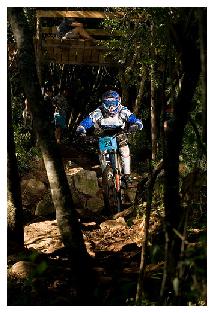

Actual caption:  dirt biker in the forest
Predicted caption:  man on bike rides through the woods


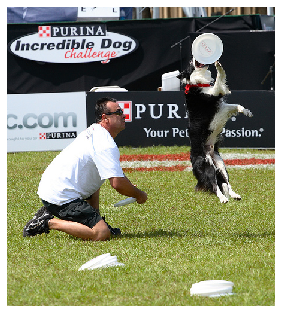

Actual caption:  black and white dog catches flying discs thrown by man
Predicted caption:  man and dog are playing frisbee on dusty field with ball in its mouth


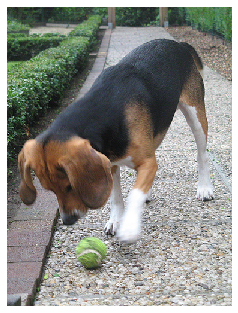

Actual caption:  beagle is playing with tennis ball
Predicted caption:  black and brown dog chewing on his mouth in the snow


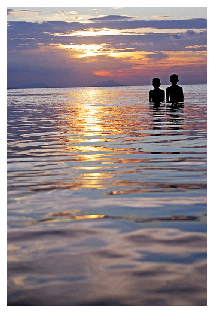

Actual caption:  two boys stand in an ocean as the sun sets
Predicted caption:  girl in swimsuit is running barefoot on the beach


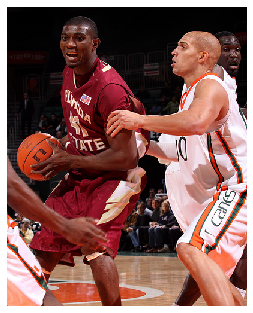

Actual caption:  basketball player in red uniform is holding the ball while player in white uniform is trying to block him
Predicted caption:  basketball player dribbles the ball while another tries to block him


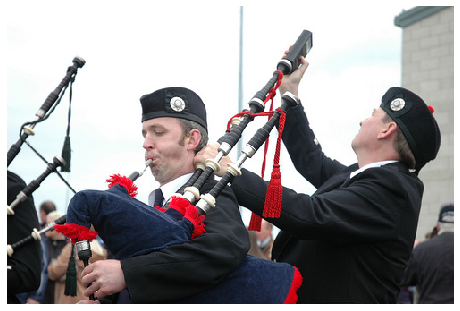

Actual caption:  man grabs the end of set of bagpipes while another man plays
Predicted caption:  two men are wearing black and one in white and one in black


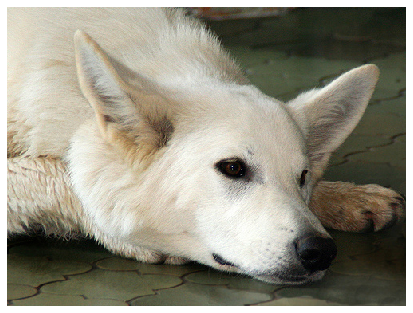

Actual caption:  closeup of white dog that is laying its head on its paws
Predicted caption:  black dog with red collar barking in the snow


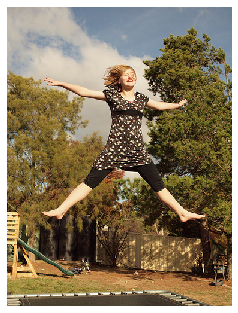

Actual caption:  girl doing the splits in the air while jumping on trampoline
Predicted caption:  little girl in pink bathing suit is jumping on trampoline


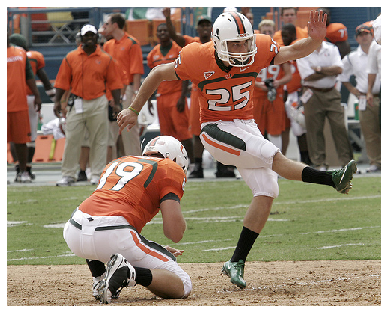

Actual caption:  holder and kicker for football team dressed in orange white and black play while onlookers behind them watch
Predicted caption:  football player in red and red uniform gets ready to tackle him


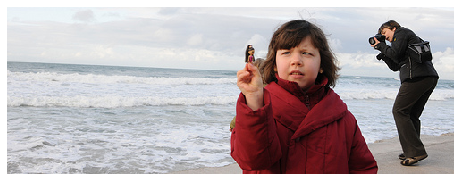

Actual caption:  child on the beach while woman takes pictures nearby
Predicted caption:  man and woman relaxing together on the beach


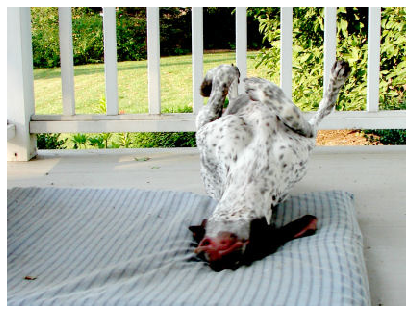

Actual caption:  dog lays on mattress on the porch
Predicted caption:  two dogs are playing tug war with their mouths open


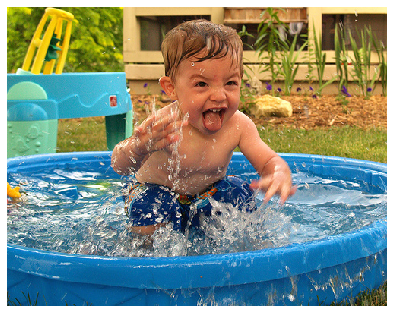

Actual caption:  toddler is making splash inside blue paddling pool
Predicted caption:  small child is playing in water water slide


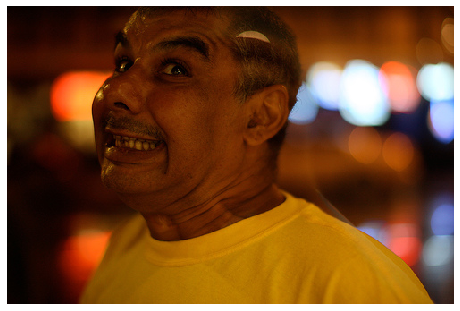

Actual caption:  man in yellow grimaces
Predicted caption:  an older man with nose ring his nose


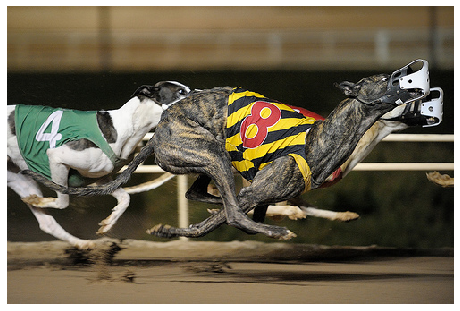

Actual caption:  group of dogs racing
Predicted caption:  the dog is wearing red jacket and is running in race


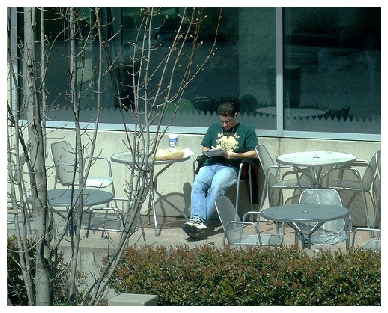

Actual caption:  man sitting at an outside table eating lunch marking on paper
Predicted caption:  the man is sleeping on top of white and yellow guitar


In [103]:

#encoding_test["3385593926_d3e9c21170"].shape
for i in range(15):
    index = np.random.randint(len(encoding_test))
    image_name = list(encoding_test.keys())[index]
    encoding = encoding_test[image_name]
    encoding = encoding.reshape((1, encoding.shape[0]))
    image = plt.imread(os.path.join("C:\\Users\\zeesh\\Machine Learning\\Image Captioning\\Flickr_Data\\Flickr_Data\\Images\\", image_name + '.jpg'))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    actual_caption = descriptions[image_name]
    print('Actual caption: ', actual_caption[0])
    predicted_caption = predict(encoding)
    print('Predicted caption: ', predicted_caption)